In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp
import os

import pysindy as ps

# Ignore matplotlib deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
np.random.seed(100)

In [4]:
from test_data import add_noise,experiment_data,normalise

# Function with unique PDE: $u(t,x)=(x+t)\arccos(sech(t))$
The function $u$ solves only the equation $u_t=u_x+\frac{u}{u_x}\cos(u)$.

In [5]:
experiment_name = 'analytic_unique_2'
n=200
u,x,t,formula = experiment_data(n_samples=n,experiment_name=experiment_name)
print(experiment_name)
print(formula)
dx=x[1]-x[0]
dt=t[1]-t[0]
x_0, x_end =x[0], x[n-1]
t_0, t_end = t[0], t[n-1]

analytic_unique_2
(t + x)*asin(1/cosh(1.7497654730547*t))


As we do not include the cosine in the feature library, the models have problems computing a PDE.
## Check now numerically that this is the unique equation

We already know that the equation is unique as the image set has non-zero measure, so let us show this by using the Jacobi criterion for analytic function. First, we have to compute the additional derivatives.

In [6]:
from numpy.linalg import matrix_rank, svd
from itertools import product

In [19]:
from utils import plot_result_jacobi
def jacobi_criterion(u,space_range,time_range,fd_orders,target_noise=0):
    u_noise = add_noise(u,target_noise)
    fd_orders = [2, 7]
    sv_ratios = np.zeros([space_range, time_range])
    svs = np.zeros([2, space_range, time_range])
    for k, fd_order in enumerate(fd_orders):
        ut = ps.FiniteDifference(order=fd_order, d=1, axis=1, drop_endpoints=False)._differentiate(u_noise, t=dt)
        utx = ps.FiniteDifference(order=fd_order, d=1, axis=0, drop_endpoints=False)._differentiate(ut, dx)
        ux = ps.FiniteDifference(order=fd_order, d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
        uxx = ps.FiniteDifference(order=fd_order, d=2, axis=0, drop_endpoints=False)._differentiate(u_noise, dx) 
        for i in range(space_range):
            for j in range(time_range):
                x_i, t_j = i * 10 + 10, j * 10 + 10
                jacobian = np.array([[ut[x_i,t_j], ux[x_i,t_j]], [utx[x_i,t_j], uxx[x_i,t_j]]]).reshape(2,2)
                jacobian=normalise(jacobian)
                sv = svd(jacobian, compute_uv=False)[-1]
                #print(svd(jacobian, compute_uv=False)[0])
                svs[k,i,j] = sv
    return svs

In [20]:
space_range = int(len(x)/10-1)
time_range = int(len(x)/10-1)
print((space_range,time_range))
fd_orders = [2, 7]
svs = jacobi_criterion(u,space_range,time_range,fd_orders)

(19, 19)


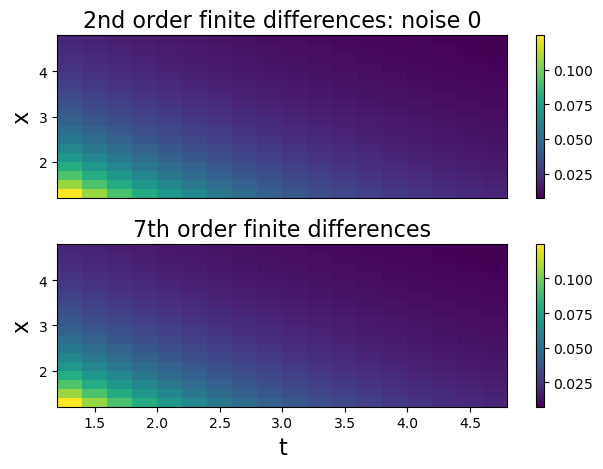

In [21]:
t_grid, x_grid = (np.arange(time_range) * 10 + 10) / len(t) * (t[len(t)-1] - t[0]) + t[0], (np.arange(space_range) * 10 + 10) / len(x) * (x[len(x)-1] - x[0]) + x[0]
plot_result_jacobi(svs,t_grid,x_grid,target_noise=0,fd_orders=fd_orders)

## With noise

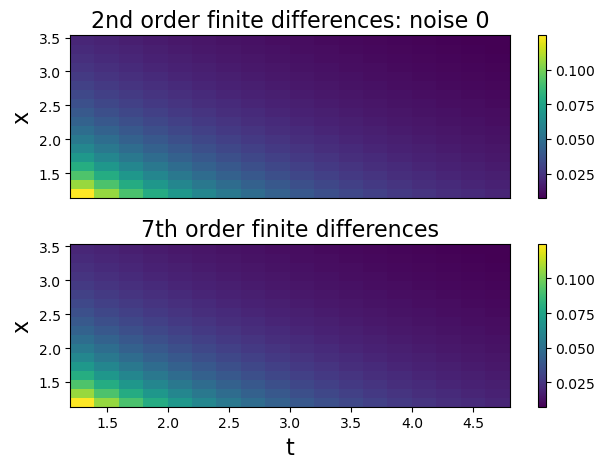

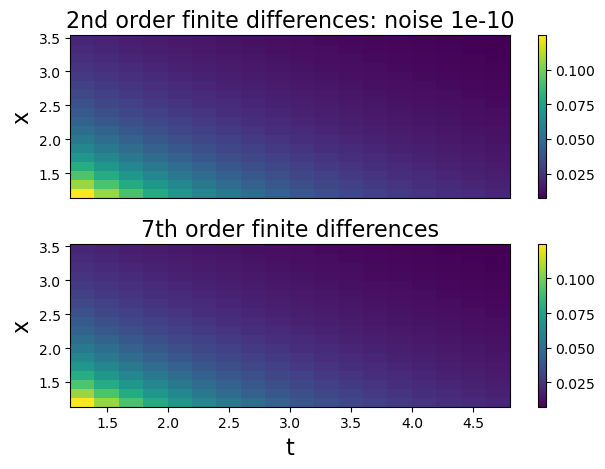

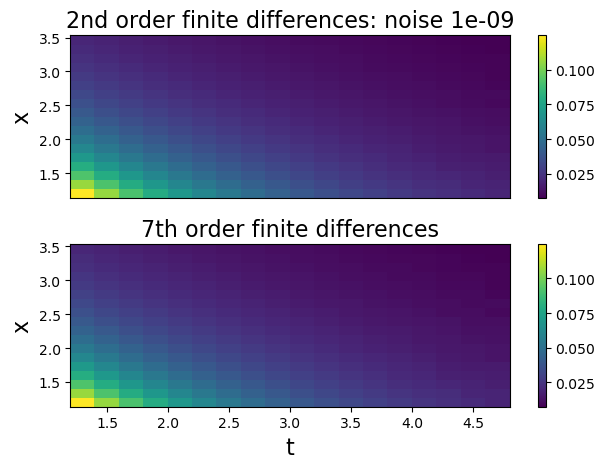

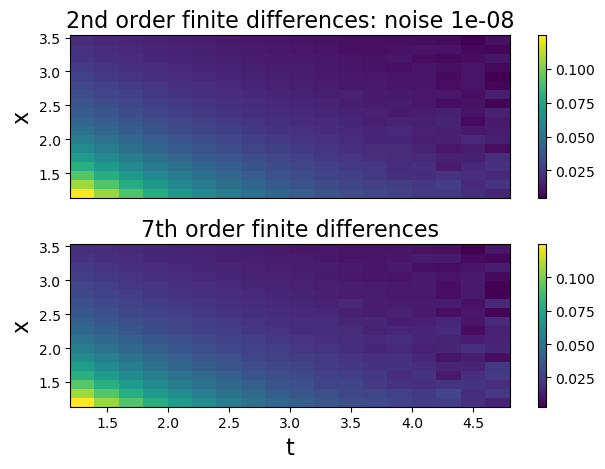

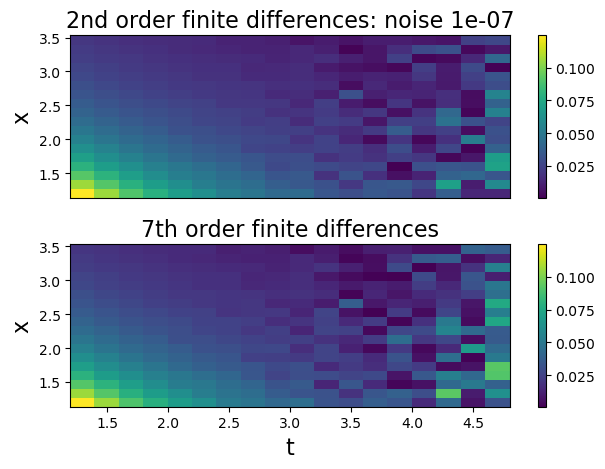

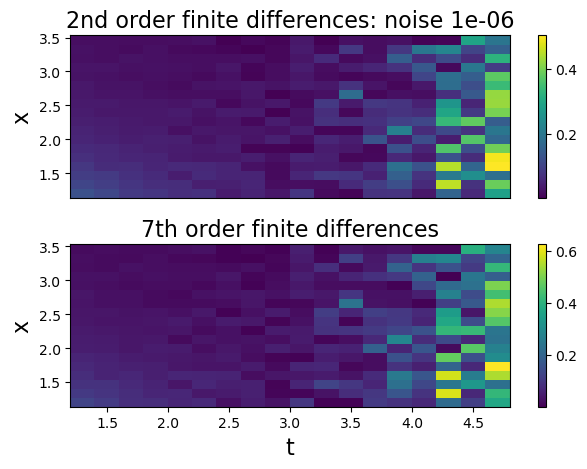

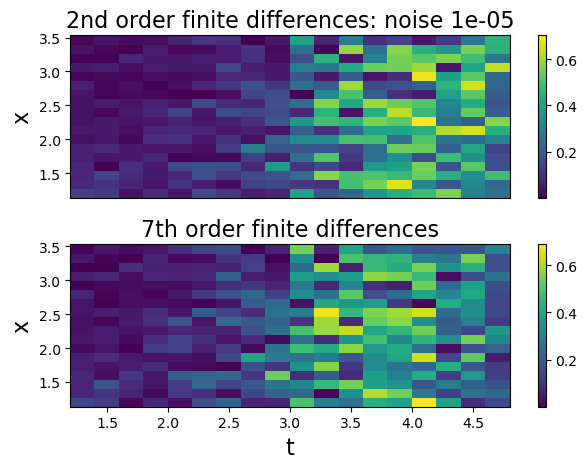

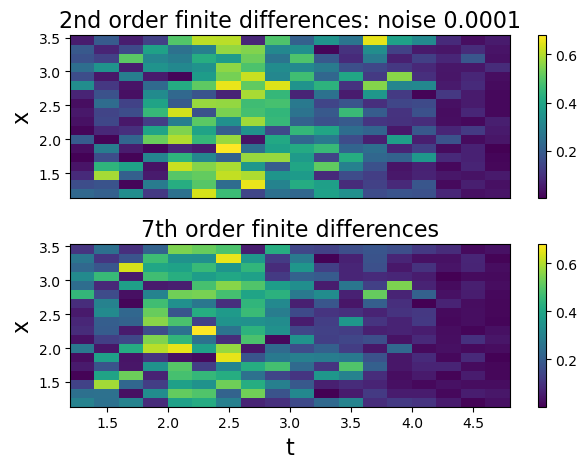

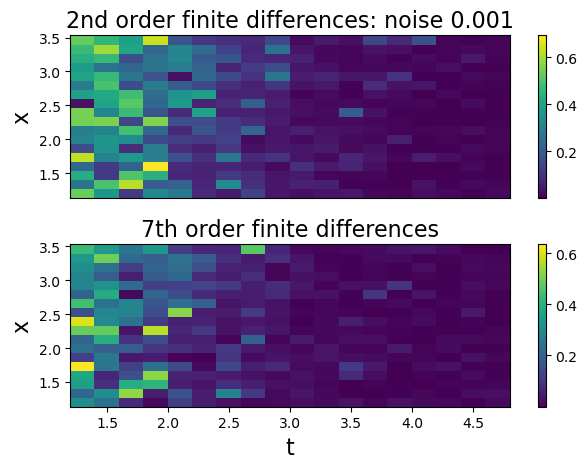

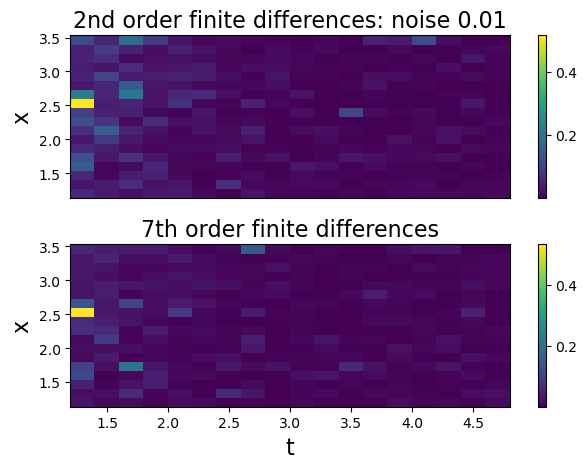

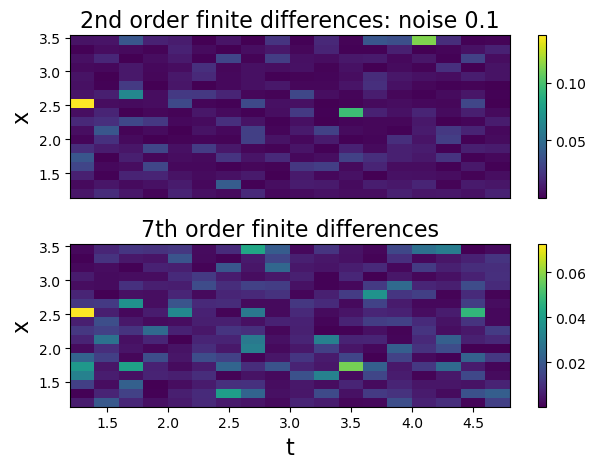

In [22]:
noise_levels = [0]+[10**(-10+i) for i in range(0,10)]
t_grid, x_grid = (np.arange(time_range) * 10 + 10) / 200 * (t[len(t)-1] - t[0]) + t[0], (np.arange(space_range) * 10 + 10) / 300 * (x[len(x)-1] - x[0]) + x[0]
space_range = int(len(x)/10-1)
time_range = int(len(x)/10-1)

for target_noise in noise_levels:
    svs = jacobi_criterion(u,space_range,time_range,fd_orders,target_noise)
    plot_result_jacobi(svs,t_grid,x_grid,target_noise=target_noise,fd_orders=fd_orders)